## MCMC for optimizing the 2-layer multiple output Neural Network

In [ ]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

Testing out some emcee functionality
https://emcee.readthedocs.io/en/v2.2.1/

In [3]:
#def lnprob(x, ivar):
#    return -0.5 * np.sum(ivar * x ** 2)

#ndim, nwalkers = 10, 100
#ivar = 1. / np.random.rand(ndim)
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]

#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
#sampler.run_mcmc(p0, 10)

In [4]:
#[np.random.rand(10) for i in range(10)]

Load previously trained NN models

In [ ]:
import keras.backend as K
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)
from keras.models import load_model
model_GPP = load_model('NN_GPP_finalize_multi-dim.h5', custom_objects={'mean_sq_err':
    mean_sq_err})
model_LHF = load_model('NN_LHF_finalize_multi-dim.h5',
    custom_objects={'mean_sq_err': mean_sq_err})

List input variables

In [6]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read in observational targets and calculated variance

In [7]:
obs_GPP = np.load(file="obs/obs_GPP_SVD_3modes.npy", allow_pickle=True)
obs_LHF = np.load(file="obs/obs_LHF_SVD_3modes.npy", allow_pickle=True)
sd_GPP = np.load(file="obs/obs_GPP_SVD_3modes_allyrs_sd.npy", allow_pickle=True)
sd_LHF = np.load(file="obs/obs_LHF_SVD_3modes_allyrs_sd.npy", allow_pickle=True)

Define normalized error function  
NOTE: still need to determine ideal choice of B (justified?)

In [111]:
#B=1.3 # weighting term
B=1.49 # midpoint(?) of combination B's (see NN_opt.xlsx)
def normerr(x):
    xt = x.reshape(1,-1)
    model_preds_GPP = model_GPP.predict(xt)
    model_preds_LHF = model_LHF.predict(xt)
    L = np.sum(((model_preds_GPP-obs_GPP)/sd_GPP)**2, axis=1) + B*np.sum(((model_preds_LHF-obs_LHF)/sd_LHF)**2, axis=1)
    return L

Define the prior //
see also https://emcee.readthedocs.io/en/v2.2.1/user/line/#marginalization-uncertainty-estimation

In [112]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    if all(x > 0) and all(x < 1):
        return 0.0
    return -np.inf

In [113]:
#p0 = np.random.rand(ndim)
p0 = np.array([10, 20, 1000, -100, 100, -70000])
print(p0)
#p0.any()
#p0.any()>=0 and p0.any()<=1
#p0.all()<=1
#all(p0>0) and all(p0<1)
lnprior(p0)

[    10     20   1000   -100    100 -70000]


-inf

Define full log prob function

In [114]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr(x)

In [115]:
print(normerr(p0), lnprob(p0))

[1.01517165e+09] -inf


Number of walkers, number of dimensions = number of parameters

In [116]:
nwalkers = 200
ndim = npar

LHC generated random initial conditions

In [14]:
#from pyDOE import *
#lhd = lhs(npar,samples=1) # default sampling criterion = random
#x0 = lhd[0,:]
#print(x0)
#x0.shape
#xt = x0.reshape(1,-1)
#print(xt)
#p0=[x0]
#print(p0)

Set up sampler

In [117]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Initialization for walkers

In [118]:
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
#print(p0)

Run Sampler

In [119]:
epochs = 1000
pos, prob, state = sampler.run_mcmc(p0, epochs)

In [120]:
#pos.shape
#prob.shape
#plt.plot(prob)
#plt.plot(pos[:,0])
sampler.chain.shape # nwalkers x epochs x ndim
sampler.chain[0,999,:] # final values for first walker

array([9.99766475e-01, 3.94725407e-03, 9.99545964e-01, 4.30838233e-01,
       2.53697548e-04, 1.27474185e-03])

Plot results

In [19]:
#for i in range(ndim):
#    plt.figure()
#    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
#    plt.title("Dimension {0:d}".format(i))
#plt.show()

In [121]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.327


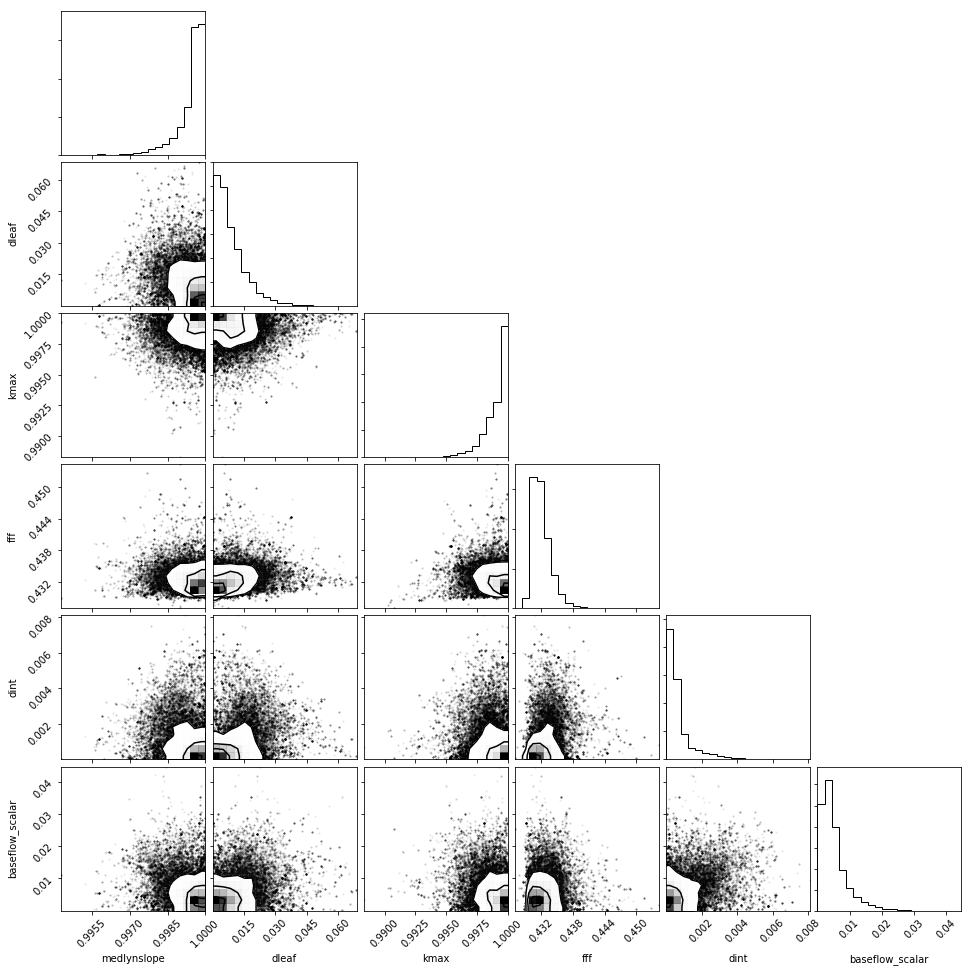

In [122]:
# discard the initial N steps
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=in_vars)
#fig.savefig("MCMC_v1.pdf")